# Anomaly Detection

### Achievement:
Using a denoising autoencoder we create a binary classifier with the following performance characteristic:

|Precision|Recall|F1  |Precision Attack|Recall Attack|
|---------|------|----|----------------|-------------|
|0.88     |0.88  |0.88|0.86            |0.90         |


## 1. Introduction

In this notebook, we will use an unsupervised learning approach to create a binary classifier based on the ideas of representation learning and anomaly detection.
We will train multiple deep learning models on benign data of the [CIC-IDS-2018 dataset](https://www.unb.ca/cic/datasets/ids-2018.html) with the goal of learning a meaningful representation of this benign data. With this approach we want to create a model that is able to classify network traffic as benign or malicious, based on the notion of traffic being similar or dissimilar to the data the model has been trained with. The rationale of using unsupervised learning is that benign data is usually easier to obtain and hence can be provided in higher volumes than malicious data.

### Autoencoder

The architecture used for the models in this notebook is based on different variations of the [Autoencoder](https://en.wikipedia.org/wiki/Autoencoder). An autoencoder is a neural network with the goal of learning a dense representation of the input data. To this end, an autoencoder is trained to reconstruct the given inputs by initially encoding the input features as dense representations (which are called latent representations or codings) and then decoding the dense representations to reconstruct the initial inputs. Using this approach, the model should learn the identity function of the input data.    
To ensure that the model actually learns a meaningful representation of the data and does not just copy the input features to the output, an autoencoder restricts the model in different ways, for example by limiting the dimensionality of the latent representations as shown in figure 1, which illustrates an undercomplete autoencoder.

<img src="img/undercomplete_autoencoder.png" alt="Undercomplete Autoencoder" style="width: 600px;"/>
<center>Figure 1: Undercomplete Autoencoder (<a href="https://www.jeremyjordan.me/autoencoders">Source</a>)</center>

Autoencoders share many characteristics with PCA and are therefore often used for dimensionality reduction or as feature extractors, but can also be utilized for anomaly detection as demonstrated in this notebook.     
The underlying assumption of using an autoencoder for the task of anomaly detection is that the autoencoder is trained on normal data only and hence learns a meaningful representation for only this kind of data. The objective of the model is to minimize the reconstruction error of a given sample, which is measured as the mean-squared error given the reconstructed output and the original input.   
As the autoencoder is trained on normal data only, it will output results with a low reconstruction error given normal data, but will not be able to reconstruct anomalous data with the same precision and hence will recreate the outputs of anomalous data with a higher reconstruction error.    
Measuring the reconstruction error of a sample and comparing it with a predefined decision boundary allows us to classify a sample as normal or anomalous.

### Autoencoder for Anomaly Detection

Given our use case of network traffic classification, the model is trained on benign data only. A validation set containing benign and malicious data is used subsequently to define the decision boundary, based on the reconstruction errors of the two types of traffic.    
At inference, a sample is fed to the autoencoder, the reconstruction error is measured and the sample subsequently classified as malicious if the reconstruction error exceeds the predefined decision boundary.

This notebook explores the following architecture variants of autoencoders:
* Undercomplete Autoencoder
* Stacked Autoencoder
* Denoising Autoencoder

## 2. Dataset Preparation

In this section we load the dataset and prepare the data for training. The preprocessed dataset from CIC-IDS-2018 can be found at [Google Drive](https://drive.google.com/open?id=1HrTPh0YRSZ4T9DLa_c47lubheKUcPl0r).

In [1]:
dataset_base_path = r'/home/glados/Development/Projects/ids-2018/processed'

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from ml_ids.data.dataset import load_dataset
from ml_ids.transform.preprocessing import create_pipeline
from ml_ids.model_selection import split_x_y
from ml_ids.visualization import plot_confusion_matrix, plot_hist, plot_threshold
from ml_ids.keras.metrics import AveragePrecisionScoreMetric
from ml_ids.keras.callbacks import OneCycleScheduler
from ml_ids.libs.dfencoder.dataframe import EncoderDataFrame
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, mean_squared_error
from sklearn.utils.multiclass import unique_labels
from functools import partial
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers, constraints
from scipy import stats
from notebook_utils import predict, evaluate_pr_roc, plot_evaluation_curves, plot_pr_threshold_curves, best_precision_for_target_recall, print_performance, filter_benign

K = keras.backend

rand_state = 42
tf.random.set_seed(rand_state)
np.random.seed(rand_state)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

%matplotlib inline

%load_ext autoreload
%autoreload 2

### 2.1 Data Loading 

In this part we load the dataset and specify two kinds of features:
1. *Features to impute*: these are features containing missing values which will be imputed in a later step.
2. *Features to omit*: these are the features that will not be used for training the model. These encompass all the features having no variance, features having the same distribution for benign and malicious traffic and features which should not be taken into account in order to obtain a better generalization of the model.

In [3]:
cols_to_impute = [
    'flow_duration',
    'flow_byts_s',
    'flow_pkts_s',
    'flow_iat_mean',
    'flow_iat_max',
    'flow_iat_min',
    'fwd_iat_tot',
    'fwd_iat_mean',
    'fwd_iat_max',
    'fwd_iat_min'
]

features_no_variance = [
    "bwd_blk_rate_avg",
    "bwd_byts_b_avg",
    "bwd_pkts_b_avg",
    "bwd_psh_flags",
    "bwd_urg_flags",
    "fwd_blk_rate_avg",
    "fwd_byts_b_avg",
    "fwd_pkts_b_avg"
]

features_same_distribution = [
    'fwd_urg_flags',
    'pkt_len_var',
    'fin_flag_cnt',
    'urg_flag_cnt',
    'cwe_flag_count',
    'down_up_ratio',
    'fwd_act_data_pkts',
    'active_max'
]

omit_cols = features_no_variance + features_same_distribution + ['timestamp', 'dst_port', 'protocol']

ids_data = load_dataset(dataset_base_path,
                        omit_cols=omit_cols,
                        preserve_neg_value_cols=['init_fwd_win_byts', 'init_bwd_win_byts'])

### 2.2 Data Splitting

In this step we split the dataset into:
- training set,
- validation set and
- test set.

The training set contains benign data only, as we will use benign data as the normal category for our anomaly detection models. The validation and test sets contain benign data as well as malicious data.

In [4]:
benign_mask = ids_data.label_is_attack == 0
attack_mask = ids_data.label_is_attack == 1

train_data, hold_data = train_test_split(ids_data[benign_mask], test_size=0.2, random_state=rand_state)

val_data_benign, test_data_benign = train_test_split(hold_data, test_size=0.5, random_state=rand_state)

val_data_attack, test_data_attack = (train_test_split(ids_data[attack_mask],
                                                      test_size=0.5,
                                                      stratify=ids_data[attack_mask].label_cat,
                                                      random_state=rand_state))


X_train_raw, y_train = split_x_y(train_data)
X_val_raw, y_val = split_x_y(val_data_benign.append(val_data_attack))
X_test_raw, y_test = split_x_y(test_data_benign.append(test_data_attack))

print('Samples:')
print('========')
print('Training: {}'.format(X_train_raw.shape))
print('Val:      {}'.format(X_val_raw.shape))
print('Test:     {}'.format(X_test_raw.shape))

print('\nTraining labels:')
print('================')
print(y_train.label.value_counts())
print('\nValidation labels:')
print('==================')
print(y_val.label.value_counts())
print('\nTest labels:')
print('============')
print(y_test.label.value_counts())

del ids_data, train_data, hold_data, val_data_benign, val_data_attack, test_data_benign, test_data_attack
gc.collect()

Samples:
Training: (10787766, 60)
Val:      (2722588, 60)
Test:     (2722589, 60)

Training labels:
Benign    10787766
Name: label, dtype: int64

Validation labels:
Benign                      1348471
DDOS attack-HOIC             343006
DDoS attacks-LOIC-HTTP       288095
DoS attacks-Hulk             230956
Bot                          143095
FTP-BruteForce                96680
SSH-Bruteforce                93794
Infilteration                 80967
DoS attacks-SlowHTTPTest      69945
DoS attacks-GoldenEye         20754
DoS attacks-Slowloris          5495
DDOS attack-LOIC-UDP            865
Brute Force -Web                306
Brute Force -XSS                115
SQL Injection                    44
Name: label, dtype: int64

Test labels:
Benign                      1348471
DDOS attack-HOIC             343006
DDoS attacks-LOIC-HTTP       288096
DoS attacks-Hulk             230956
Bot                          143096
FTP-BruteForce                96680
SSH-Bruteforce                93795
Inf

11

### 2.3 Data Preparation

Here we prepare the datasets by performing the following steps:
- imputation of missing data and
- normalization of data using a `MinMaxScaler`.

In [5]:
pipeline, get_col_names = create_pipeline(X_train_raw, 
                                          imputer_strategy='median',
                                          imputer_cols=cols_to_impute,
                                          scaler=MinMaxScaler)

X_train = pipeline.fit_transform(X_train_raw)
X_val = pipeline.transform(X_val_raw)
X_test = pipeline.transform(X_test_raw)

X_val_benign = filter_benign(X_val, y_val)

column_names = get_col_names()

print('Samples:')
print('========')
print('Training: {}'.format(X_train.shape))
print('Val:      {}'.format(X_val.shape))
print('Test:     {}'.format(X_test.shape))

print('\nMissing values:')
print('===============')
print('Training: {}'.format(np.count_nonzero(np.isnan(X_train))))
print('Val:      {}'.format(np.count_nonzero(np.isnan(X_val))))
print('Test:     {}'.format(np.count_nonzero(np.isnan(X_test))))

print('\nScaling:')
print('========')
print('Training: min={}, max={}'.format(np.min(X_train), np.max(X_train)))
print('Val:      min={}, max={}'.format(np.min(X_val), np.max(X_val)))
print('Test:     min={}, max={}'.format(np.min(X_test), np.max(X_test)))

Samples:
Training: (10787766, 60)
Val:      (2722588, 60)
Test:     (2722589, 60)

Missing values:
Training: 0
Val:      0
Test:     0

Scaling:
Training: min=0.0, max=1.0
Val:      min=0.0, max=2.2449962079994723
Test:     min=0.0, max=2.5524120420747187


## 3. Model Training

In this section we train and evaluate various types of autoencoder architectures to create a binary classifier using anomaly detection.

The following autoencoder architectures are evaluated:
- Undercomplete Autoencoder
- Stacked Autoencoder
- Denoising Autoencoder

All models are trained using [Tensorflow 2](https://www.tensorflow.org/) in combination with [Keras](https://keras.io/).    
We utilize the training set containing benign data only to train the model and the benign portion of the validation set to detect overfitting.    
Furthermore, we use a custom Keras callback named *AveragePrecisionScoreMetric* to calculate the average precision score, using the corresponding [scikit-learn function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html), after each epoch on the complete validation set containing benign and malicious data.
This score is used to perform early stopping of the training process in order to obtain the best performing model.    
Inputs are normalized using a `MinMaxScaler` and reproduced using the `Sigmoid` activation function. We utilize the `Adam` optimizer with a `binary crossentropy` loss per ouput unit to train the model, resulting in a multilabel classifier model.

As a first step we define the training parameters for all models.

In [6]:
input_dims = X_train.shape[1]
epochs = 50
batch_size = 4096

### 3.1 Undercomplete Autoencoder

The undercomplete autoencoder represents the simplest type of autoencoder, as it uses a single restricted hidden layer containing the latent representations of the data.    
Figure 2 illustrates the architecture of an undercomplete autoencoder.

<img src="img/undercomplete_autoencoder.png" alt="Undercomplete Autoencoder" style="width: 600px;"/>
<center>Figure 2: Undercomplete Autoencoder (<a href="https://www.jeremyjordan.me/autoencoders">Source</a>)</center>

We choose to restrict the latent layer to 30 units cutting the number of features in half. The number of units was determined empirically by training and comparing multiple hyperparameter values.

In [12]:
K.clear_session()
gc.collect()

simple_ae = models.Sequential([
    layers.Dense(30, activation='elu', input_shape=[input_dims]),
    layers.Dense(input_dims, activation='sigmoid')
])

simple_ae.compile(optimizer='adam', loss='binary_crossentropy')
simple_ae.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                1830      
_________________________________________________________________
dense_1 (Dense)              (None, 60)                1860      
Total params: 3,690
Trainable params: 3,690
Non-trainable params: 0
_________________________________________________________________


### Training

In [ ]:
early_stopping = callbacks.EarlyStopping(monitor='val_auprc', 
                                         mode='max',
                                         patience=15,                             
                                         restore_best_weights=True)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_auprc', 
                                        mode='max', 
                                        factor=0.2, 
                                        patience=3, 
                                        min_lr=0.0001)

mc = callbacks.ModelCheckpoint(filepath='models/simple_autoencoder_model.h5',
                               monitor='val_auprc', 
                               mode='max',
                               save_best_only=True, 
                               verbose=0)

hist = simple_ae.fit(x=X_train, 
                     y=X_train, 
                     validation_data=(X_val_benign, X_val_benign),
                     batch_size=batch_size,
                     epochs=epochs,
                     callbacks=[
                         AveragePrecisionScoreMetric(X_val=X_val, y_val=y_val.label_is_attack, batch_size=16384),
                         early_stopping,
                         reduce_lr,
                         mc
                     ])

[Output omitted for brevity]

### Validation

Inspecting the learning curves we observe that the model does not overfit the training data.

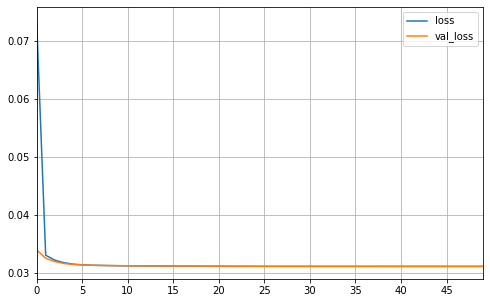

In [14]:
plot_hist(hist)

The plot of the average precision score shows a significant increase of the score until epoch 23. Afterwards the performance stabilizes and does not increase significantly.

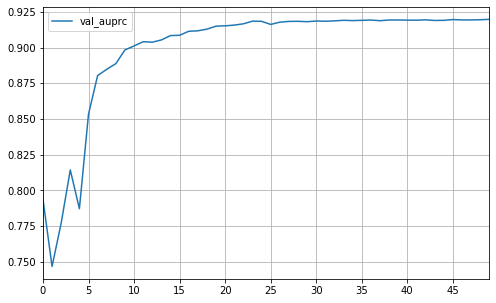

In [15]:
plot_hist(hist, metrics=['val_auprc'])

For this model we obtain an average precision score of `0.91972`.

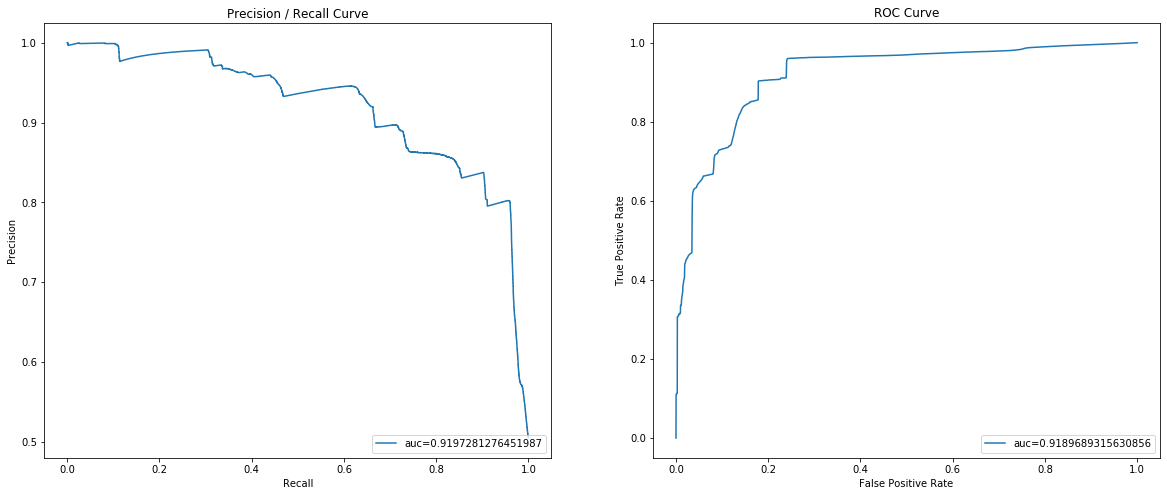

In [8]:
simple_ae = models.load_model('models/simple_autoencoder_model.h5')
pred_train_simple_ae = predict(simple_ae, X_train, y_train.label_is_attack)
pred_val_simple_ae = predict(simple_ae, X_val, y_val.label_is_attack)

plot_evaluation_curves(pred_val_simple_ae)

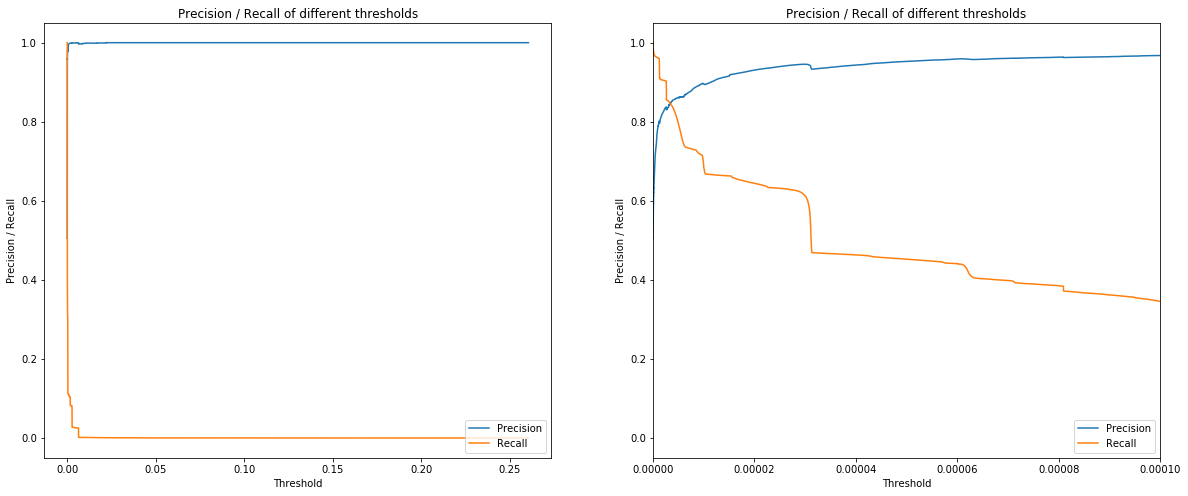

In [9]:
plot_pr_threshold_curves(pred_val_simple_ae, pr_plot_lim=[0, 0.0001])

In the next step we choose a threshold to define the decision boundary, used to separate benign and malicious data, by utilizing the validation data.    
The threshold is chosen to obtain a minimum recall of `0.9`.

In [10]:
threshold_simple_ae = best_precision_for_target_recall(pred_val_simple_ae, target_recall=0.9)
print(threshold_simple_ae)

2.63808195226977e-06


The following plot illustrates the distributions of benign and malicious data, outlining the decision boundary.    
We can observe that the overlap of both traffic classes is quite large.

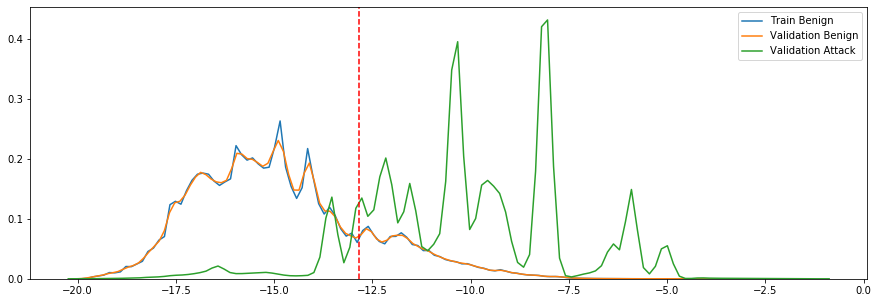

In [11]:
plot_threshold(pred_train_simple_ae, pred_val_simple_ae, threshold_simple_ae, transform=np.log)

### Performance

The performance of this model seems compelling, given that the model is rather simple.

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.82      0.85   1348471
           1       0.84      0.90      0.87   1374117

    accuracy                           0.86   2722588
   macro avg       0.86      0.86      0.86   2722588
weighted avg       0.86      0.86      0.86   2722588

Confusion Matrix:


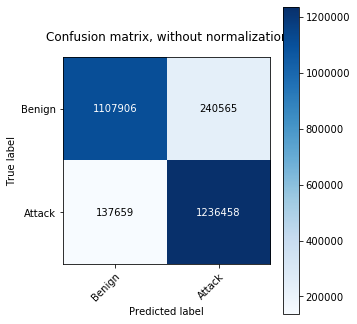

Misclassifications by attack category:


,misclassified,total,percent_misclassified
Infilteration,54751,80967,0.676214
Bot,80560,143095,0.562983
Benign,240565,1348471,0.178398
Brute Force -Web,28,306,0.091503
Brute Force -XSS,10,115,0.086957
SQL Injection,2,44,0.045455
DDoS attacks-LOIC-HTTP,2269,288095,0.007876
DoS attacks-Slowloris,26,5495,0.004732
DoS attacks-Hulk,12,230956,0.000052
DoS attacks-GoldenEye,1,20754,0.000048


In [12]:
print_performance(y_val, pred_val_simple_ae, threshold=threshold_simple_ae)

### 3.2 Stacked Autoencoder

The main idea of the stacked autoencoder is to modify an undercomplete autoencoder by adding additional hidden layers, transforming the undercomplete autoencoder into a deep learning model. Adding more layers allows the autoencoder to create more complex representations, which can enhance performance. However, one has to pay attention not to make the autoencoder too powerfull as it might simply recreate the outputs by copying the given inputs if possible.   
Figure 3 illustrated the architecture of a stacked autoencoder.

<img src="img/stacked_autoencoder.png" alt="Stacked Autoencoder" style="width: 600px;"/>
<center>Figure 3: Stacked Autoencoder (<a href="https://www.jeremyjordan.me/autoencoders">Source</a>)</center>

The autoencoder trained in this notebook is comprised of four hidden layers with a latent representation layer containing 10 units. We also use a `UnitNorm` kernel constraint to restrict the model further. The parameters were determined empirically. 

In [26]:
K.clear_session()
gc.collect()

activation = 'elu'
dropout= 0.1

stacked_ae = models.Sequential([
    layers.Dense(50, activation=activation, kernel_constraint=constraints.UnitNorm(axis=0), input_shape=(input_dims,)),
    layers.Dense(30, activation=activation, kernel_constraint=constraints.UnitNorm(axis=0)),
    layers.Dense(20, activation=activation, kernel_constraint=constraints.UnitNorm(axis=0)),
    layers.Dense(10, activation=activation, kernel_constraint=constraints.UnitNorm(axis=0)),
    layers.Dense(20, activation=activation),
    layers.Dropout(dropout),
    layers.Dense(30, activation=activation),
    layers.Dropout(dropout),
    layers.Dense(50, activation=activation),
    layers.Dropout(dropout),
    layers.Dense(input_dims, activation='sigmoid')
])

stacked_ae.compile(optimizer='adam', loss='binary_crossentropy')
stacked_ae.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_4 (Dense)              (None, 20)                220       
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 30)                6

### Training

In [ ]:
early_stopping = callbacks.EarlyStopping(monitor='val_auprc', 
                                         mode='max',
                                         patience=15,                             
                                         restore_best_weights=True)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_auprc', 
                                        mode='max', 
                                        factor=0.2, 
                                        patience=3, 
                                        min_lr=0.0001)

mc = callbacks.ModelCheckpoint(filepath='models/stacked_autoencoder_model.h5',
                               monitor='val_auprc', 
                               mode='max',
                               save_best_only=True, 
                               verbose=0)

hist = stacked_ae.fit(x=X_train, 
                      y=X_train, 
                      validation_data=(X_val_benign, X_val_benign),
                      batch_size=batch_size,
                      epochs=epochs,
                      callbacks=[
                          AveragePrecisionScoreMetric(X_val=X_val, y_val=y_val.label_is_attack, batch_size=16384),
                          early_stopping,
                          reduce_lr,
                          mc
                      ])

[Output omitted for brevity]

### Validation

The learning curves suggest that the model does not overfit the training data. As we use `Dropout` layers, the validation loss is lower than the training loss.

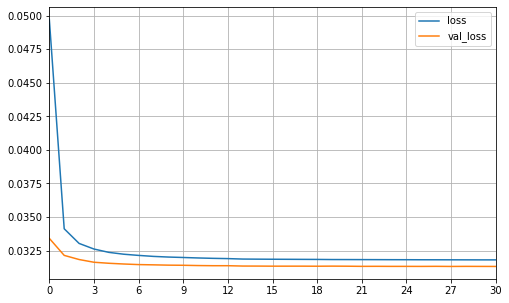

In [28]:
plot_hist(hist)

The plot of the average precision score shows a rather unstable performance, with the best score obtained at epoch 15.

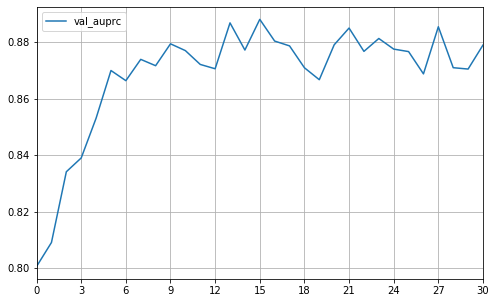

In [29]:
plot_hist(hist, metrics=['val_auprc'])

With this model we obtain an average precision score of `0.88549`.

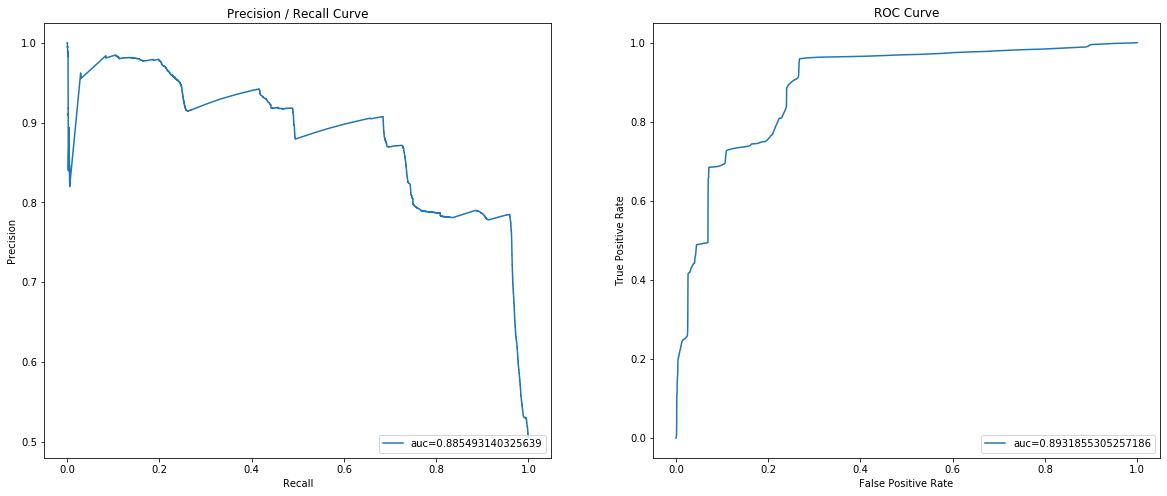

In [13]:
stacked_ae = models.load_model('models/stacked_autoencoder_model.h5')
pred_train_stacked_ae = predict(stacked_ae, X_train, y_train.label_is_attack)
pred_val_stacked_ae = predict(stacked_ae, X_val, y_val.label_is_attack)

plot_evaluation_curves(pred_val_stacked_ae)

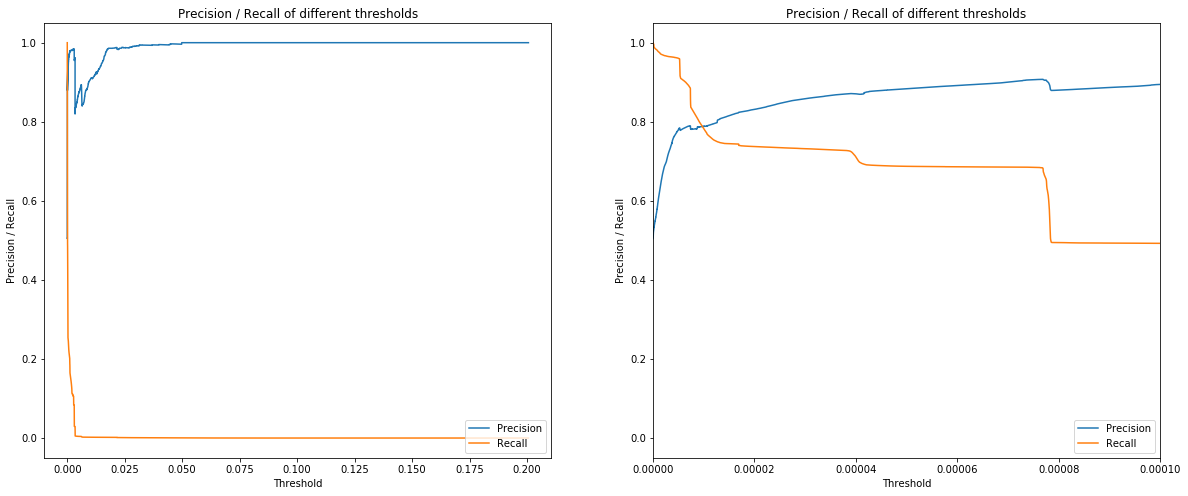

In [14]:
plot_pr_threshold_curves(pred_val_stacked_ae, pr_plot_lim=[0, 0.0001])

Once again we choose a threshold to define the decision boundary using the validation data.    
The threshold is chosen to obtain a minimum recall of `0.9`.

In [15]:
threshold_stacked_ae = best_precision_for_target_recall(pred_val_stacked_ae, target_recall=0.9)
print(threshold_stacked_ae)

6.451055123624049e-06


The distribution plot shows considerable overlap of benign and malicious traffic.   

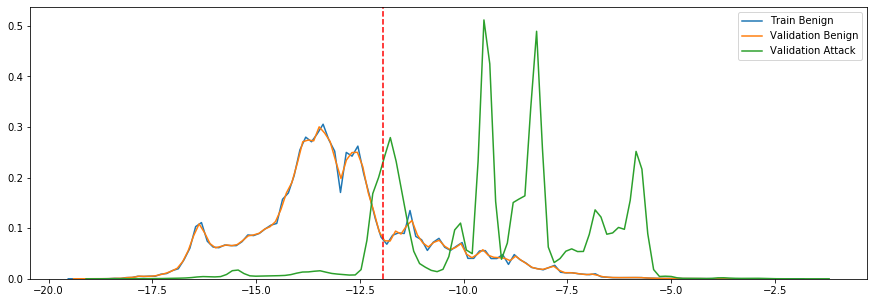

In [16]:
plot_threshold(pred_train_stacked_ae, pred_val_stacked_ae, threshold_stacked_ae, transform=np.log)

### Performance

The performance of the stacked autoencoder falls short of the performance of the undercomplete autoencoder, which is somewhat surprising.

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.75      0.81   1348471
           1       0.79      0.90      0.84   1374117

    accuracy                           0.83   2722588
   macro avg       0.83      0.83      0.82   2722588
weighted avg       0.83      0.83      0.82   2722588

Confusion Matrix:


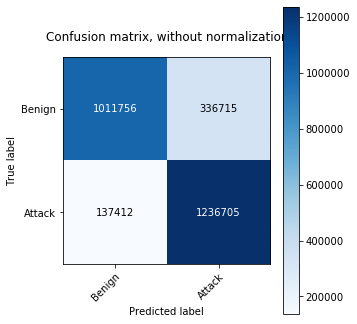

Misclassifications by attack category:


,misclassified,total,percent_misclassified
Infilteration,45002,80967,0.555807
Bot,76485,143095,0.534505
Benign,336715,1348471,0.249701
SQL Injection,5,44,0.113636
Brute Force -Web,18,306,0.058824
DDoS attacks-LOIC-HTTP,15479,288095,0.053729
DoS attacks-GoldenEye,100,20754,0.004818
DoS attacks-Hulk,322,230956,0.001394
DDOS attack-HOIC,1,343006,0.000003


In [17]:
print_performance(y_val, pred_val_stacked_ae, threshold=threshold_stacked_ae)

### 3.3 Denoising Autoencoder

Another variant of the autoencoder is the denoising autoencoder. In this version, the model is restricted not by limiting the size of the hidden layers but by adding additional noise to the inputs. The objective of the model is to recreate the inputs without containing the noise.    
Figure 4 illustrates the architecture of a denoising autoencoder.

<img src="img/denoising_autoencoder.png" alt="Denoising Autoencoder" style="width: 600px;"/>
<center>Figure 4: Denosing Autoencoder (<a href="https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html">Source</a>)</center>

Denoising autoencoders are typically used in image processing to denoise images but can also be applied to tabular data using a simple method orginally introduced by [Porto Seguro](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/44629) as the winning strategy in a Kaggle competition.     
The idea is to randomly shuffle a portion of the input data row-wise on the complete training set. The percentage of values shuffled are determined by a likelihood, which acts as a hyperparameter of the model. This approach introduces noise and ensures that the noise originates from the same distribution as the original data.   
The following approach is further inspired by, and uses utilities introduced in, a blog post from [Michael Klear](https://towardsdatascience.com/how-to-apply-self-supervision-to-tabular-data-introducing-dfencoder-eec21c4afaef).

The denoising autoencoder presented in this notebook is overcomplete, hence it contains more units in the hidden layers than in the input layer. The model consists of five layers containing 512 units per layer. The likelihood for introducing noise is set to 15%. The parameters were determined empirically. 

In [18]:
X_train_swapped = EncoderDataFrame(pd.DataFrame(data=X_train).copy()).swap(likelihood=.15).values
X_val_benign_swapped = EncoderDataFrame(pd.DataFrame(data=X_val_benign).copy()).swap(likelihood=.15).values

In [60]:
K.clear_session()
gc.collect()

activation = 'elu' 
dropout = 0.1

denoising_ae = models.Sequential([
    layers.Dense(512, activation=activation, input_shape=[input_dims]),
    layers.Dropout(dropout),
    layers.Dense(512, activation=activation),
    layers.Dropout(dropout),
    layers.Dense(512, activation=activation),
    layers.Dropout(dropout),
    layers.Dense(512, activation=activation),
    layers.Dropout(dropout),
    layers.Dense(512, activation=activation),
    layers.Dropout(dropout),
    layers.Dense(input_dims, activation='sigmoid')
])

denoising_ae.compile(optimizer='adam', loss='binary_crossentropy')
denoising_ae.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               31232     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               2

### Training

In [ ]:
early_stopping = callbacks.EarlyStopping(monitor='val_auprc', 
                                         mode='max',
                                         patience=15,                             
                                         restore_best_weights=True)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_auprc', 
                                        mode='max', 
                                        factor=0.2, 
                                        patience=3, 
                                        min_lr=0.0001)

mc = callbacks.ModelCheckpoint(filepath='models/denoising_autoencoder_model.h5', 
                               monitor='val_auprc', 
                               mode='max',
                               save_best_only=True, 
                               verbose=0)

hist = denoising_ae.fit(x=X_train_swapped, 
                        y=X_train, 
                        validation_data=(X_val_benign_swapped, X_val_benign),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=[
                            AveragePrecisionScoreMetric(X_val=X_val, y_val=y_val.label_is_attack, batch_size=16384),
                            early_stopping,
                            reduce_lr,
                            mc
                        ])

[Output omitted for brevity]

### Validation

The learning curves suggest that the model does not overfit the training data. As we use `Dropout` layers the validation loss is lower than the training loss.

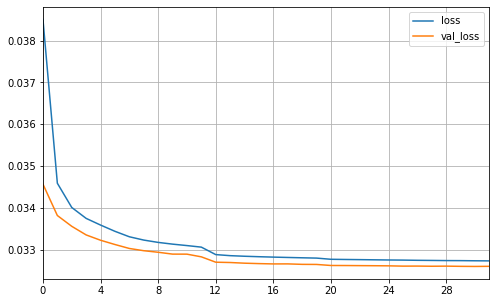

In [62]:
plot_hist(hist)

The plot of the average precision score unveils a very unstable performance progression, with the best score obtained at epoch 17.

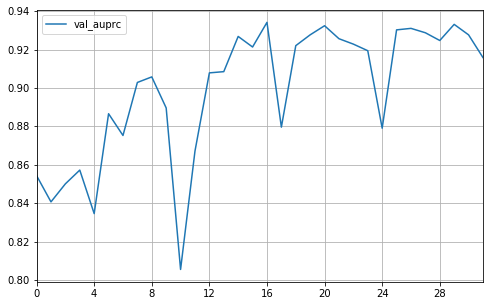

In [63]:
plot_hist(hist, metrics=['val_auprc'])

Using this model we obtain an average precision score of `0.93419`.

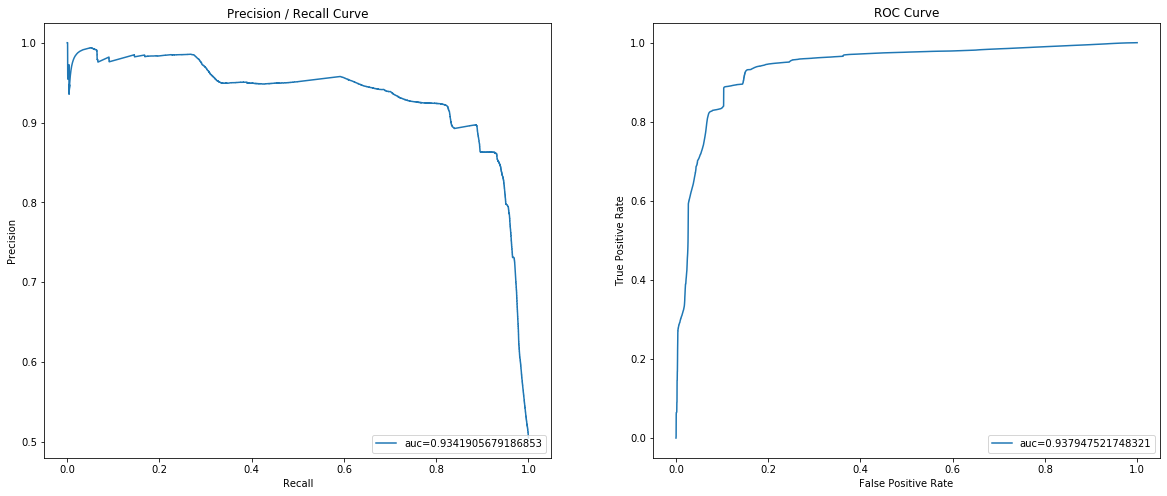

In [19]:
denoising_ae = models.load_model('models/denoising_autoencoder_model.h5')
pred_train_denoising_ae = predict(denoising_ae, X_train, y_train.label_is_attack)
pred_val_denoising_ae = predict(denoising_ae, X_val, y_val.label_is_attack)

plot_evaluation_curves(pred_val_denoising_ae)

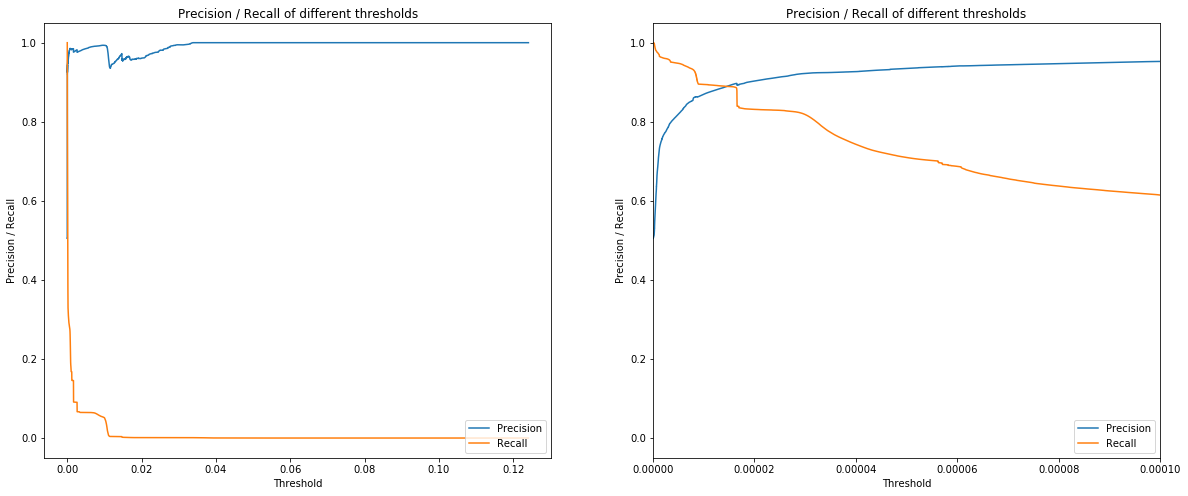

In [20]:
plot_pr_threshold_curves(pred_val_denoising_ae, pr_plot_lim=[0, 0.0001])

As before, we choose a threshold to define the decision boundary using the validation data.    
The threshold is chosen to obtain a minimum recall of `0.9`.

In [21]:
threshold_denoising_ae = best_precision_for_target_recall(pred_val_denoising_ae, target_recall=0.9)
print(threshold_denoising_ae)

8.805178334767583e-06


The distribution plot shows some overlap of benign and malicious traffic.

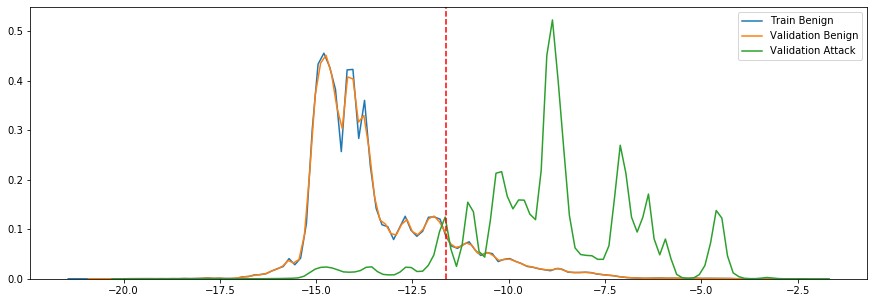

In [22]:
plot_threshold(pred_train_denoising_ae, pred_val_denoising_ae, threshold_denoising_ae, transform=np.log)

### Performance

The performance of the denoising autoencoder surpasses the performance of the other models.

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87   1348471
           1       0.86      0.90      0.88   1374117

    accuracy                           0.88   2722588
   macro avg       0.88      0.88      0.88   2722588
weighted avg       0.88      0.88      0.88   2722588

Confusion Matrix:


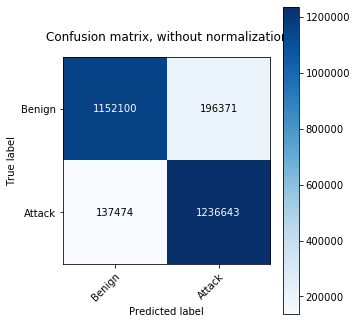

Misclassifications by attack category:


,misclassified,total,percent_misclassified
Infilteration,63161,80967,0.780083
SQL Injection,22,44,0.500000
Bot,67411,143095,0.471093
Brute Force -Web,129,306,0.421569
Brute Force -XSS,46,115,0.400000
DoS attacks-Slowloris,1137,5495,0.206915
Benign,196371,1348471,0.145625
DDoS attacks-LOIC-HTTP,5563,288095,0.019310
DDOS attack-LOIC-UDP,3,865,0.003468
DoS attacks-GoldenEye,2,20754,0.000096


In [23]:
print_performance(y_val, pred_val_denoising_ae, threshold=threshold_denoising_ae)

### 3.4 Performance Comparison and Model Selection

Comparing the models we obtain the following performance characteristics:

|Model                    |PR Score   |Precision|Recall  |F1      |Precision Attack|Recall Attack|
|-------------------------|-----------|---------|--------|--------|----------------|-------------|
|Undercomplete Autoencoder|0.91972    |0.86     |0.86    |0.86    |0.84            |0.90         |
|Stacked Autoencoder      |0.88549    |0.83     |0.83    |0.84    |0.79            |0.90         |
|Denoising Autoencoder    |**0.93419**|**0.88** |**0.88**|**0.88**|**0.86**        |**0.90**     |

We see that the denoising autoencoder obtains the best performance, with the undercomplete autoencoder falling short only slightly, which is rather impressive given that the undercomplete autoencoder is based on a much simpler architecture.    
Neverthless we use the denoising autoencoder going forward, as it has best performance.

### 3.5 Model Performance Omitting the Top Misclassified Attack Class

In this section we test the performance of the classifier on the validation set, omitting the attack class with the most misclassified samples. The rationale being, that choosing the decision boundary without including this class might lead to a better overall performance of the classifier on the remaining attack classes, at the cost of not being able to detect attacks of this class.

As roughly `78%` of all `Infiltration` traffic was misclassified, this class is chosen to be omitted from the validation set.

As a result we gain a slightly better average precision score of `0.94698`, with precision of `0.90` and recall of `0.90`. The slight increase in performance does not warrant the removal of the class though. The removal even lowers the detection rate of other classes such as `Bot`, which now has a misclassification rate of `81%` instead of `47%` because of the modified decision boundary.

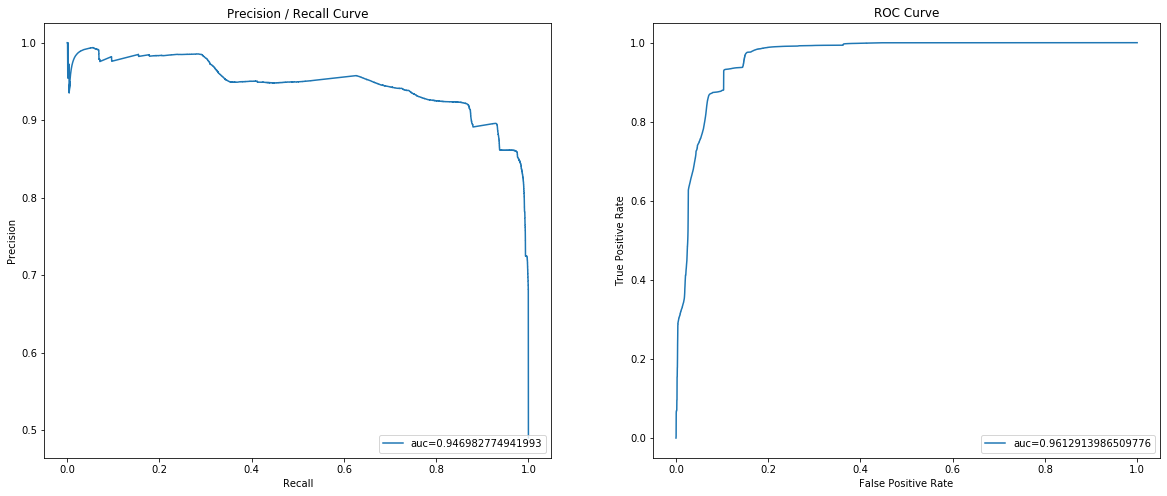

In [24]:
top_misclassified_mask = (y_val.label != 'Infilteration')
X_val_wo_top = X_val[top_misclassified_mask]
y_val_wo_top = y_val[top_misclassified_mask]

pred_denoising_ae_wo_top = predict(denoising_ae, X_val_wo_top, y_val_wo_top.label_is_attack)
plot_evaluation_curves(pred_denoising_ae_wo_top)

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90   1348471
           1       0.89      0.90      0.90   1293150

    accuracy                           0.90   2641621
   macro avg       0.90      0.90      0.90   2641621
weighted avg       0.90      0.90      0.90   2641621

Confusion Matrix:


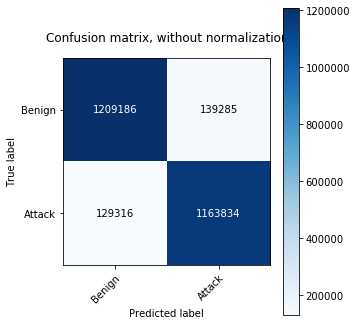

Misclassifications by attack category:


,misclassified,total,percent_misclassified
Bot,116141,143095,0.811636
SQL Injection,26,44,0.590909
Brute Force -Web,134,306,0.437908
Brute Force -XSS,50,115,0.434783
DoS attacks-Slowloris,1141,5495,0.207643
Benign,139285,1348471,0.103291
DDoS attacks-LOIC-HTTP,11498,288095,0.039910
DDOS attack-LOIC-UDP,4,865,0.004624
DoS attacks-Hulk,317,230956,0.001373
DoS attacks-GoldenEye,4,20754,0.000193


In [25]:
threshold_denoising_ae_wo_top = best_precision_for_target_recall(pred_denoising_ae_wo_top, target_recall=0.9)
print_performance(y_val_wo_top, pred_denoising_ae_wo_top, threshold=threshold_denoising_ae_wo_top)

## 4. Performance on Test Set

In this section we evaluate the performance on the test set using the best performing model, in our case the denoising autoencoder.

Average Precision Score: 0.9341264614111068

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87   1348471
           1       0.86      0.90      0.88   1374118

    accuracy                           0.88   2722589
   macro avg       0.88      0.88      0.88   2722589
weighted avg       0.88      0.88      0.88   2722589

Confusion Matrix:


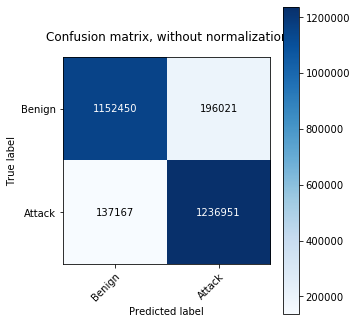

Misclassifications by attack category:


,misclassified,total,percent_misclassified
Infilteration,63138,80967,0.779799
Brute Force -XSS,59,115,0.513043
SQL Injection,22,43,0.511628
Bot,67187,143096,0.469524
Brute Force -Web,142,305,0.465574
DoS attacks-Slowloris,1115,5495,0.202912
Benign,196021,1348471,0.145365
DDoS attacks-LOIC-HTTP,5498,288096,0.019084
DDOS attack-LOIC-UDP,5,865,0.005780
DoS attacks-GoldenEye,1,20754,0.000048


In [26]:
pred_test_denoising_ae = predict(denoising_ae, X_test, y_test.label_is_attack)

test_avg_pr_score = average_precision_score(pred_test_denoising_ae.y_true, pred_test_denoising_ae.rec_error)
print('Average Precision Score: {}\n'.format(test_avg_pr_score))    
print_performance(y_test, pred_test_denoising_ae, threshold=threshold_denoising_ae)

We obtain similar results as observed on the validation set:

|PR Score|Precision|Recall|F1  |Precision Attack|Recall Attack|
|--------|---------|------|----|----------------|-------------|
|0.93419 |0.88     |0.88  |0.88|0.86            |0.90         |

## 5. Conclusion

Summarizing our experiments using anomaly detection, we can conclude that the performance of the resulting model is not sufficient for real-world usage and is considerably worse than the performance of the machine learning models created in previous experiments.    
Moreover, the predictions of this estimator are very sensitive to the chosen value of the decision boundary, which may only be reliably determined given sufficient malicious data. This circumstance mitigates the usefulness of this approach somewhat, as the biggest advantage of this method lies in the assumption that only benign data is necessary to create the estimator and collection of malicious data is not required or severly limited.

Nevertheless, the demonstrated approach could be useful in situations where malicious training data is only available in low volumes or not available at all. If no malicious training data is available, choosing a decision boundary could be done by defining a sensible confidence interval given the distribution of benign samples and adjusting the boundary on the arrival of new data.